In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(RColorBrewer)
library(pheatmap)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
## remove the x-axis text and tick
## plot.margin to adjust the white space between each plot.
## ... pass any arguments to VlnPlot in Seurat
modify_vlnplot<- function(obj, 
                          feature, 
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  p<- VlnPlot(obj, features = feature, pt.size = pt.size, ... )  + 
    xlab("") + ylab(feature) + ggtitle("") + 
    theme(legend.position = "none", 
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(), 
          axis.title.y = element_text(size = rel(1), angle = 0), 
          axis.text.y = element_text(size = rel(1)), 
          plot.margin = plot.margin ) 
  return(p)
}

## extract the max value of the y axis
extract_max<- function(p){
  ymax<- max(ggplot_build(p)$layout$panel_scales_y[[1]]$range$range)
  return(ceiling(ymax))
}


## main function
StackedVlnPlot<- function(obj, features,
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  
  plot_list<- purrr::map(features, function(x) modify_vlnplot(obj = obj,feature = x, ...))
  
  # Add back x-axis title to bottom plot. patchwork is going to support this?
  plot_list[[length(plot_list)]]<- plot_list[[length(plot_list)]] +
    theme(axis.text.x=element_text(), axis.ticks.x = element_line())
  
  # change the y-axis tick to only max value 
  ymaxs<- purrr::map_dbl(plot_list, extract_max)
  plot_list<- purrr::map2(plot_list, ymaxs, function(x,y) x + 
                            scale_y_continuous(breaks = c(y)) + 
                            expand_limits(y = y))

  p<- patchwork::wrap_plots(plotlist = plot_list, ncol = 1)
  return(p)
}

In [3]:
run_highlight <- function(sce,sample_num,ptsize=2){
  myumap <- sce@reductions$umap@cell.embeddings %>%
    as.data.frame() %>%
    cbind(sample = sce@meta.data$orig.ident)
  all_sample = unique(myumap$sample)
  for (s in all_sample) {
    subumap <- myumap
    subumap$sample <- ifelse(subumap$sample==s,'yes','no')
    p = ggplot(subumap,aes(x= UMAP_1 , y = UMAP_2 ,color = sample)) +
      geom_point(size = ptsize , alpha =2,show.legend = F) +
      scale_color_manual(values = c('yes'='#D95F02','no'='grey65'))+
      labs(title = s)+
      theme_classic()+
      theme(axis.title = element_text(size = 15,colour = 'black'),
            axis.text = element_text(size = 12,colour = 'black'),
            plot.title = element_text(size = 20,colour = 'black',hjust = 0.5))
    ggsave(p,filename=paste0(sample_num,'_fig1_umap_highlight_',s,'.pdf'),width=7,height=7)
  }
}

In [4]:
#Sample1 UMAP-----------------------------------------------
sce1 <- readRDS('Sample1.rds')
sce1

An object of class Seurat 
32285 features across 187 samples within 1 assay 
Active assay: RNA (32285 features, 0 variable features)

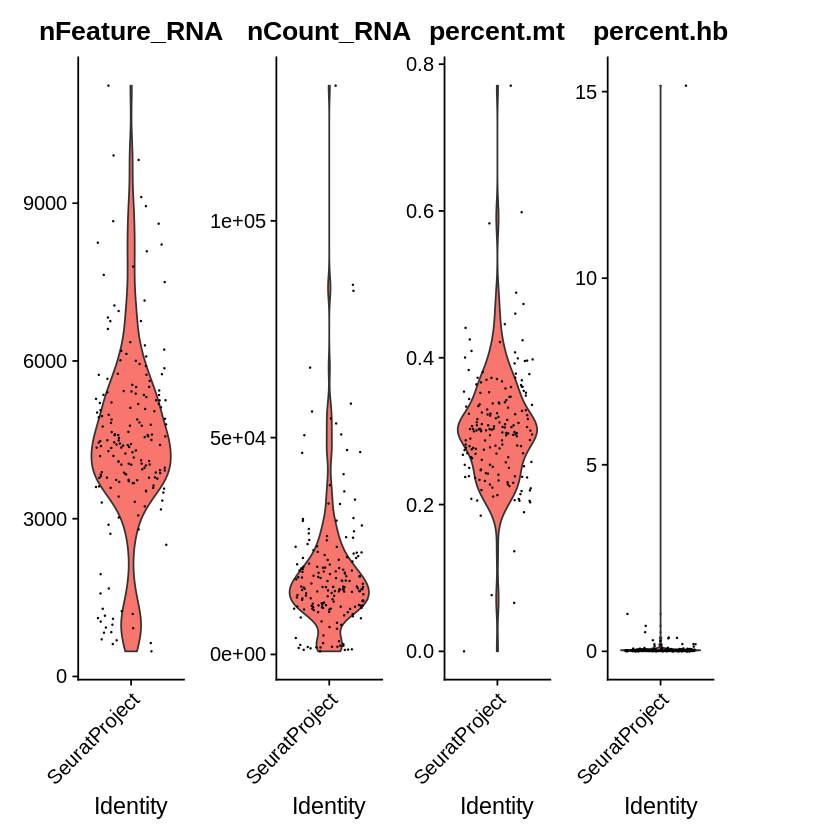

In [5]:
sce1[["percent.mt"]] <- PercentageFeatureSet(sce1, pattern = "^Mt")
sce1[["percent.hb"]] <- PercentageFeatureSet(sce1, pattern = "^Hb")
VlnPlot(sce1, features = c("nFeature_RNA", "nCount_RNA", "percent.mt","percent.hb"), ncol = 5)

In [6]:
summary(sce1@meta.data)

  orig.ident          nCount_RNA      nFeature_RNA     percent.mt    
 Length:187         Min.   :   712   Min.   :  478   Min.   :0.0000  
 Class :character   1st Qu.: 11134   1st Qu.: 3739   1st Qu.:0.2578  
 Mode  :character   Median : 15513   Median : 4429   Median :0.3024  
                    Mean   : 18982   Mean   : 4516   Mean   :0.3044  
                    3rd Qu.: 21808   3rd Qu.: 5353   3rd Qu.:0.3408  
                    Max.   :131173   Max.   :11235   Max.   :0.7707  
   percent.hb      
 Min.   : 0.00000  
 1st Qu.: 0.01359  
 Median : 0.02272  
 Mean   : 0.13235  
 3rd Qu.: 0.04409  
 Max.   :15.15982  

In [7]:
sce1 <- subset(sce1, subset = percent.hb < 1)
sce1

An object of class Seurat 
32285 features across 185 samples within 1 assay 
Active assay: RNA (32285 features, 0 variable features)

In [8]:
sce1 <- NormalizeData(sce1, normalization.method = "LogNormalize", scale.factor = 10000)
all.genes1 <- rownames(sce1)
sce1 <- ScaleData(sce1, features = all.genes1)

Centering and scaling data matrix



When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


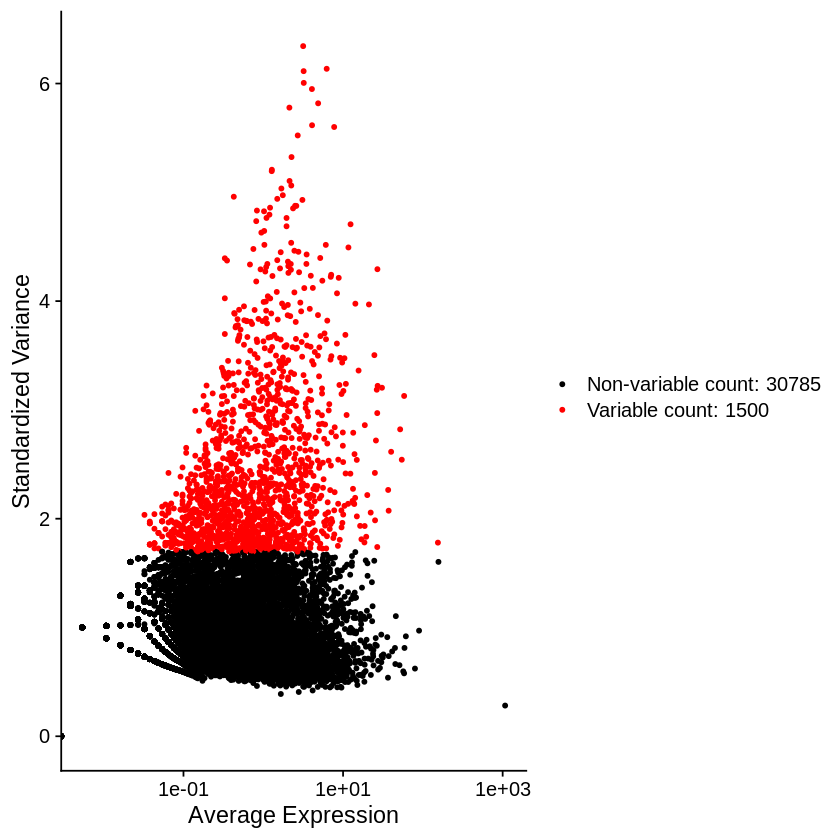

PC_ 1 
Positive:  Actn2, Ryr2, Trdn, Ldb3, Myom1, Myo18b, Rbm20, Rbm24, Myh6, Nebl 
	   Trim55, Mlip, Ppargc1a, Sorbs2, Nexn, Fhod3, Casz1, Tnnt2, Myocd, Tnni3k 
	   Ppp1r14c, Atp2a2, Tmod1, Mybpc3, Fgf13, Bves, Tnnc1, 4930512H18Rik, Casq2, Popdc2 
Negative:  Postn, Vav3, Pcdh9, Abca8a, Nrk, P3h2, Mecom, Fli1, Itga8, Nkain3 
	   Eya4, Tnxb, Adam12, Pid1, Clmp, Robo2, Piezo2, Grik2, Gpm6b, Col24a1 
	   Slc2a13, 8030451A03Rik, Hpse2, Plcl1, Abca6, Gucy1a2, Tnc, Khdrbs2, Pknox2, Lsp1 
PC_ 2 
Positive:  Postn, Ptprm, Abca8a, Itga8, P3h2, Pknox2, Itpr2, Mecom, Fli1, Pid1 
	   Hmga2, Atp8b1, Mrvi1, Gnao1, Astn2, Eya4, Pdgfrb, Gm17276, Gpm6b, Col24a1 
	   Hpse2, Clmp, Slc12a2, Nexmif, Matn2, Gnas, Robo2, Eng, Egflam, Tnc 
Negative:  Gpm6a, Pkhd1l1, Wdr17, Upk3b, Muc16, Mbp, Stk26, Upk1b, Efemp1, Plxna4 
	   Dpp4, Smpd3, Msln, Adam33, Fras1, Krt7, Gm29266, Wwc1, Ezr, Ildr2 
	   Cdh3, Wt1, Ccdc88c, Adgrd1, Rhpn2, Rbm47, Golm1, Hpgd, Myo5b, Myo1d 
PC_ 3 
Positive:  Hsp90ab1, Ckm, Gapdh, Eef1a1, 

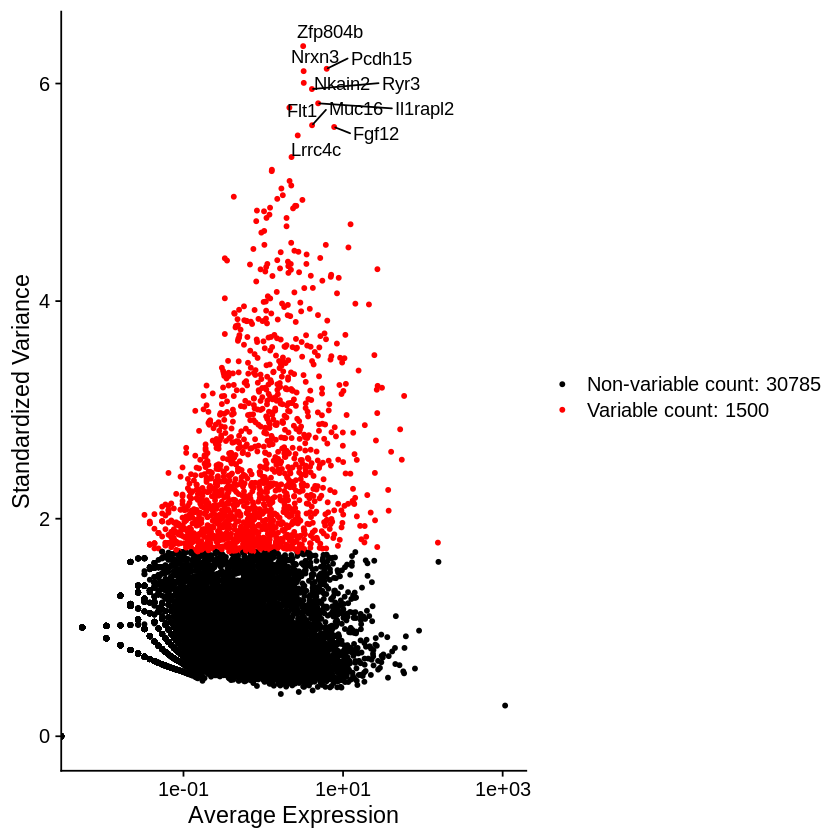

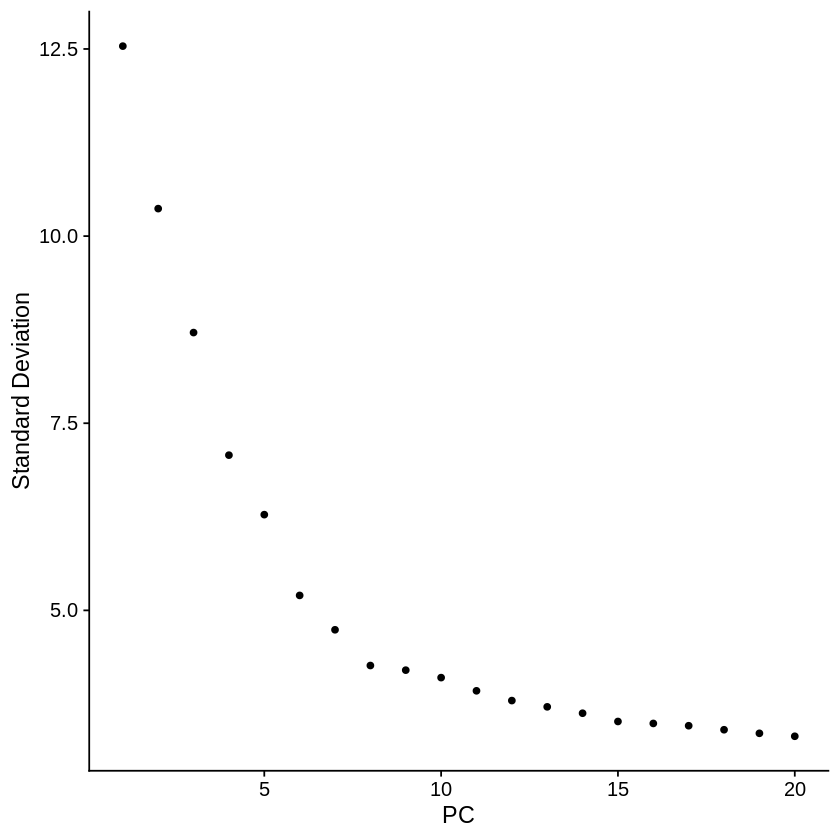

In [9]:
sce1 <- FindVariableFeatures(sce1, nfeatures = 1500)
# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(sce1), 10)
plot1 <- VariableFeaturePlot(sce1)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1
plot2
# Find the optimal PCs
sce1 <- RunPCA(sce1, features = VariableFeatures(object = sce1))
ElbowPlot(sce1)

In [10]:
sce1 <- sce1 %>%
  FindNeighbors(reduction = "pca", dims = 1:15) %>%
  FindClusters(resolution = c(0.1,0.3,0.5,0.7)) %>%
  RunUMAP(reduction = "pca", dims = 1:15)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 185
Number of edges: 4432

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9345
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 185
Number of edges: 4432

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8491
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 185
Number of edges: 4432

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7743
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 185
Number of edges: 4432

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7155
Number of communities: 5
Elapsed time: 0 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:53:34 UMAP embedding parameters a = 0.9922 b = 1.112

14:53:34 Read 185 rows and found 15 numeric columns

14:53:34 Using Annoy for neighbor search, n_neighbors = 30

14:53:34 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:53:34 Writing NN index file to temp file /tmp/RtmpCappUP/file18996e4561450c

14:53:34 Searching Annoy index using 1 thread, search_k = 3000

14:53:34 Annoy recall = 100%

14:53:34 Commencing smooth kNN distance calibration using 1 thread

14:53:35 Initializing fr

Loading required package: fields

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.7-0 (2021-06-25) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: ROCR

Loading required package: modes



NULL


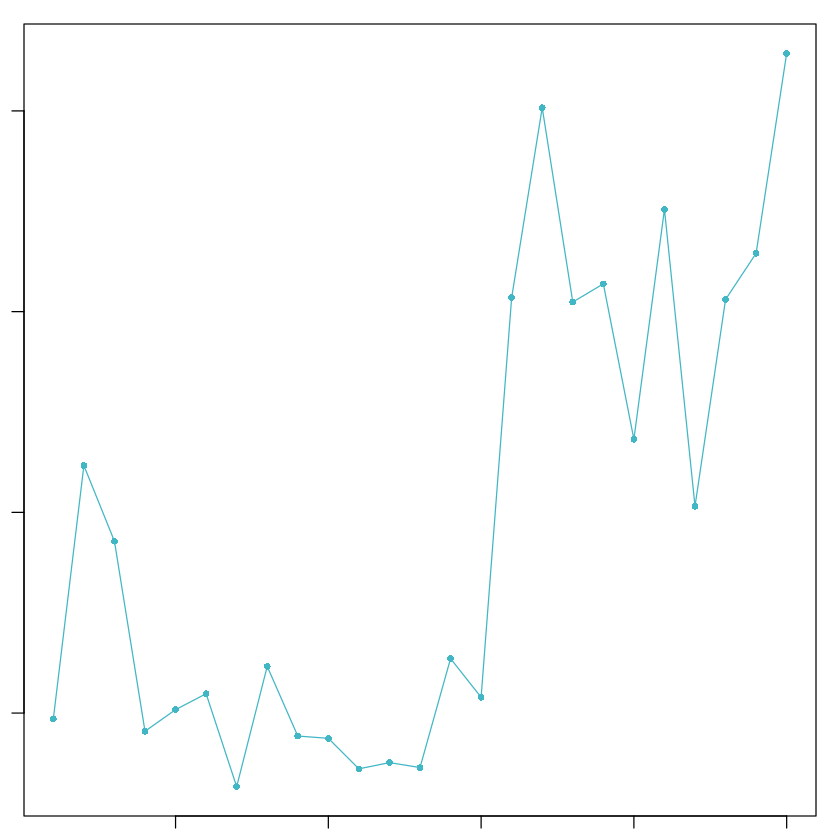

In [11]:
library(DoubletFinder)
sweep.res.list <- paramSweep_v3(sce1, PCs = 1:15, sct = FALSE)
for(i in 1:length(sweep.res.list)){
  if(length(sweep.res.list[[i]]$pANN[is.nan(sweep.res.list[[i]]$pANN)]) != 0){
    if(i != 1){
      sweep.res.list[[i]] <- sweep.res.list[[i - 1]]
    }else{
      sweep.res.list[[i]] <- sweep.res.list[[i + 1]]
    }
  }
}
sweep.stats <- summarizeSweep(sweep.res.list, GT = FALSE)
bcmvn <- find.pK(sweep.stats)
pk_v <- as.numeric(as.character(bcmvn$pK))
pk_good <- pk_v[bcmvn$BCmetric==max(bcmvn$BCmetric)]
nExp_poi <- round(0.1*length(colnames(sce1)))

In [12]:
sce1 <- doubletFinder_v3(sce1, PCs = 1:15, pN = 0.25, pK = pk_good, nExp = nExp_poi, reuse.pANN = FALSE, sct = FALSE)


[1] "Creating 62 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


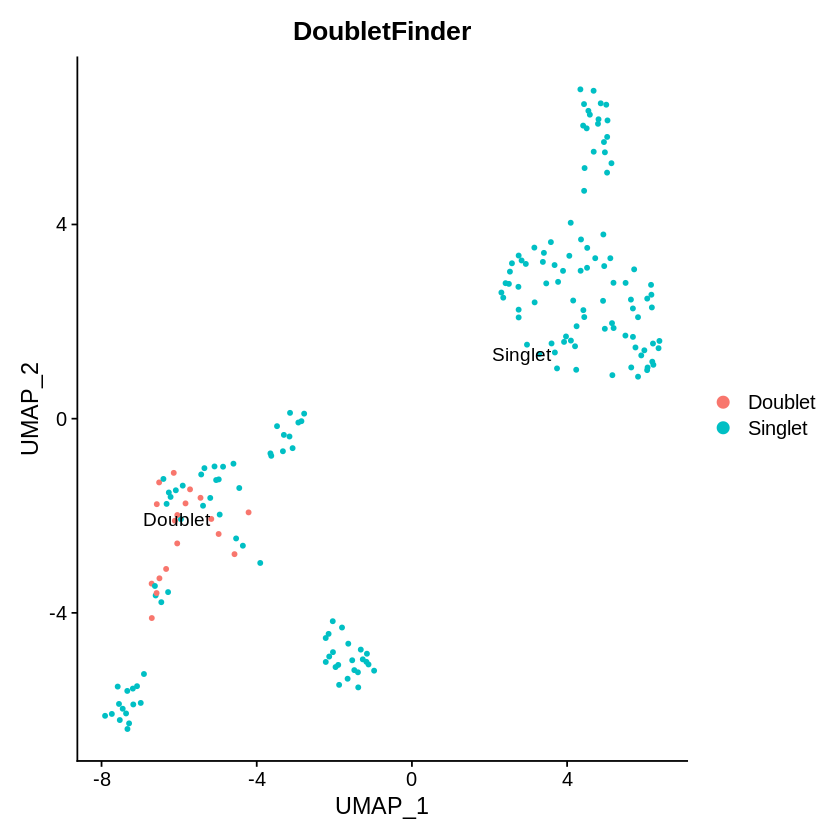

In [13]:
colnames(sce1@meta.data)[ncol(sce1@meta.data)]="DoubletFinder"
DimPlot(sce1, reduction = "umap",label=T,group.by='DoubletFinder')

In [14]:
sce1<-subset(sce1,DoubletFinder=='Singlet')

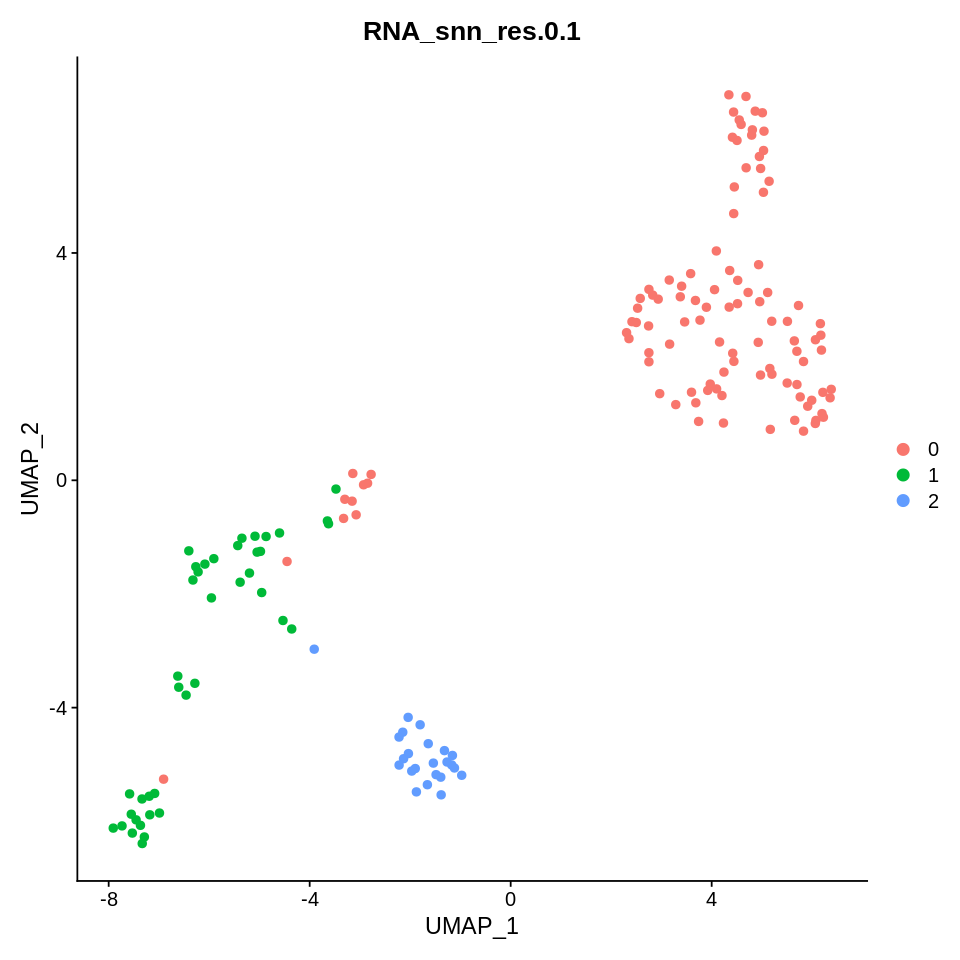

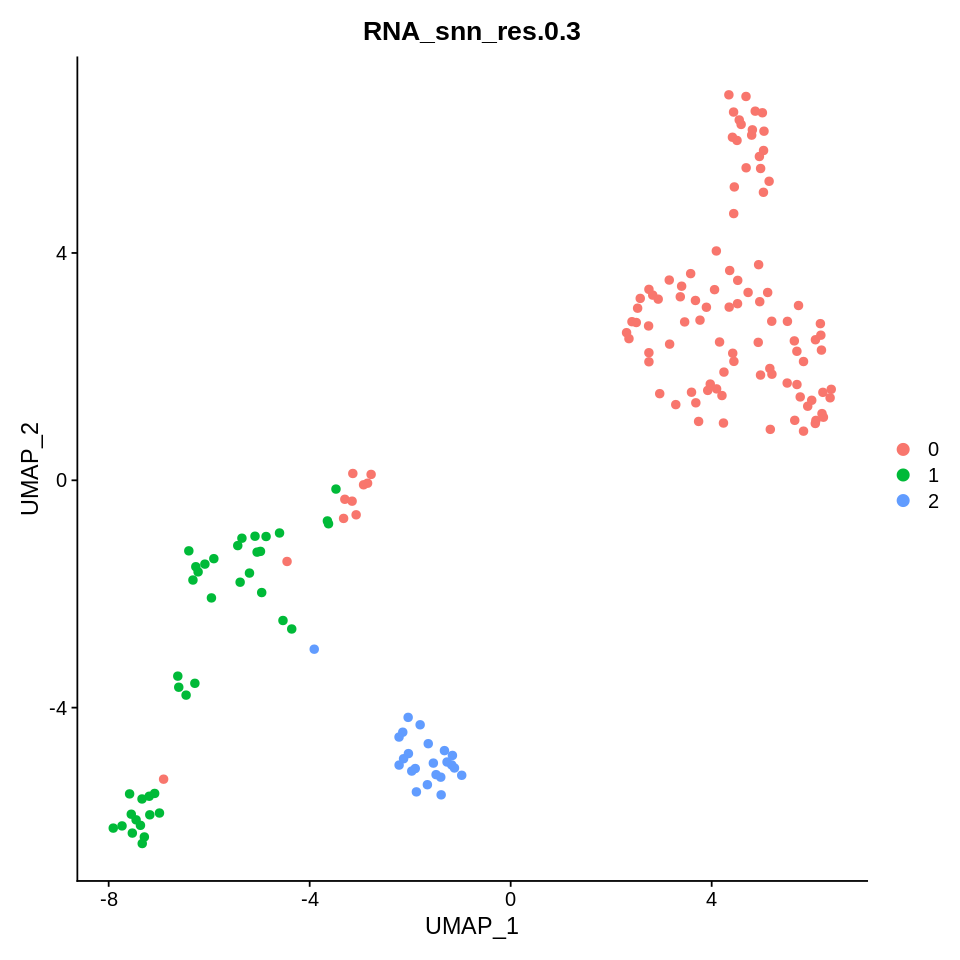

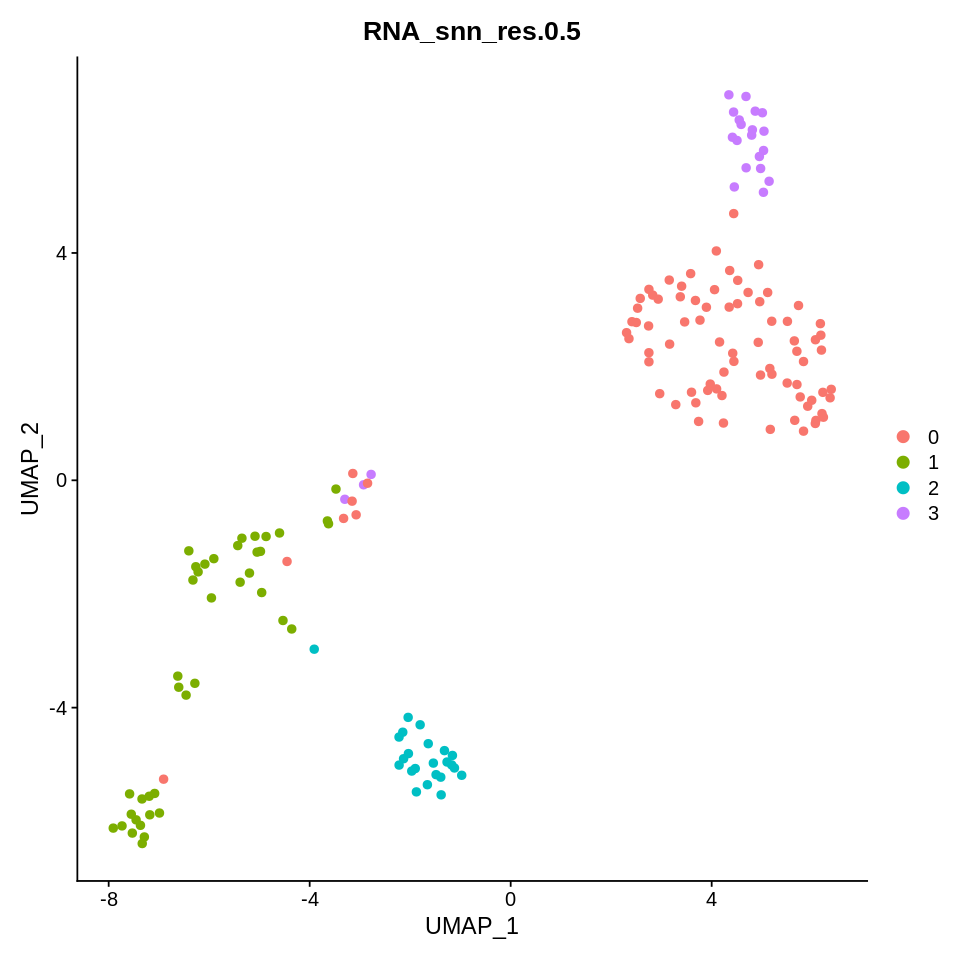

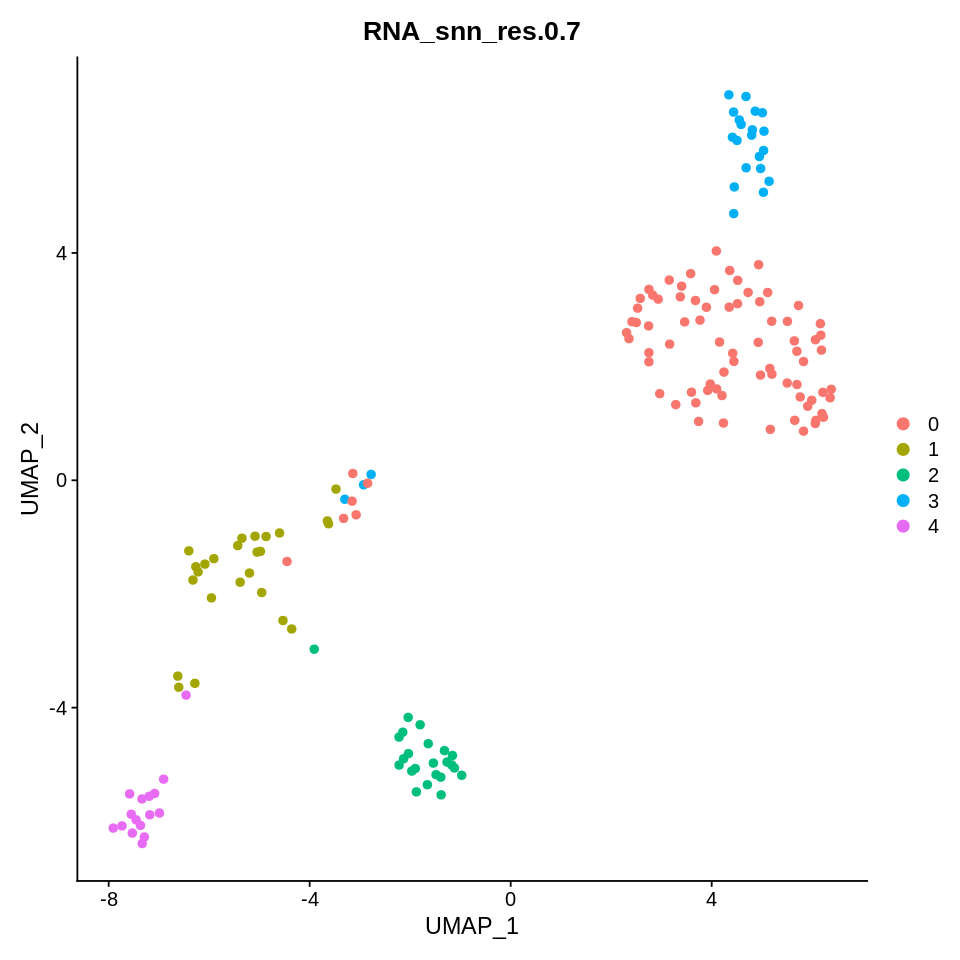

In [17]:
options(repr.plot.height=8,repr.plot.width=8)
DimPlot(sce1,pt.size = 2,group.by="RNA_snn_res.0.1")
DimPlot(sce1,pt.size = 2,group.by="RNA_snn_res.0.3")
DimPlot(sce1,pt.size = 2,group.by="RNA_snn_res.0.5")
DimPlot(sce1,pt.size = 2,group.by="RNA_snn_res.0.7")

In [18]:
av<-AverageExpression (sce1,group.by='seurat_clusters',assay='RNA')
av=av[[1]]
head(av)
cg=names(tail(sort(apply(av,1,sd)),1000))
av<-as.data.frame(av[cg,])
M=cor(av,method='spearman')

,0,1,2,3,4
Xkr4,4.385097075,0.925158489,3.85642203,0.56652047,0.7784508
Gm1992,0.409821679,0.117822236,0.09575018,0.03876450,0.0000000
Gm19938,0.138891323,0.042024738,0.01992679,0.00000000,0.0000000
Gm37381,0.000000000,0.000000000,0.00000000,0.04462971,0.0000000
Rp1,0.007343007,0.064263115,0.06027764,0.00000000,0.0000000
Sox17,0.036935806,0.004770253,0.00000000,0.01598319,0.0000000


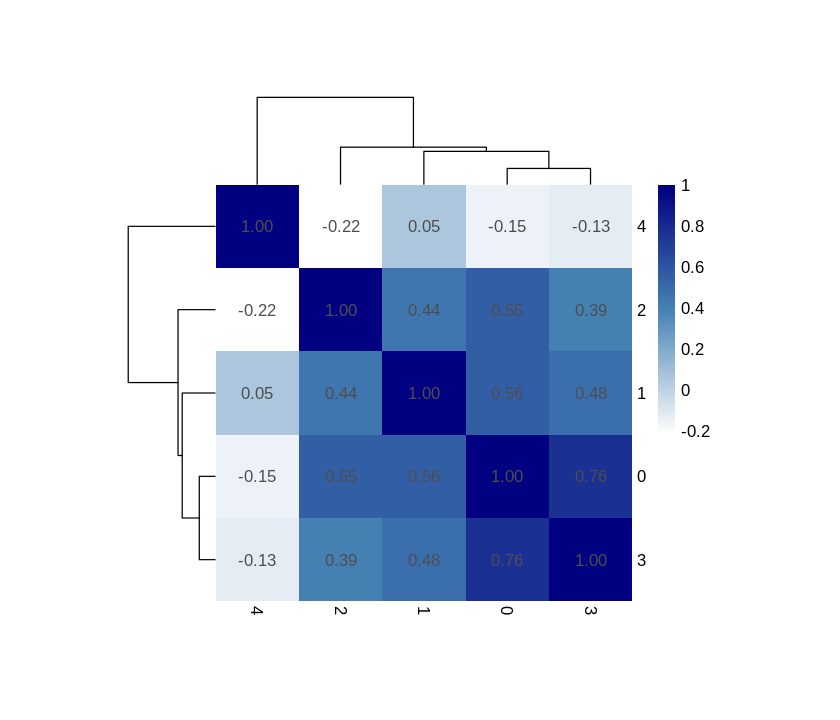

In [19]:
options(repr.plot.height=6,repr.plot.width=7)
p<-pheatmap(M,display_numbers = TRUE,fontsize_number=10,cluster_col=T,cluster_row=T,color = colorRampPalette(c("white",'steelblue',"navy"))(100),border=F,cellwidth=50,cellheight=50)

In [20]:
all.markers <- FindAllMarkers(sce1, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
all.markers %>%
  group_by(cluster) %>%
  slice_max(n = 5, order_by = avg_log2FC)
write.table(all.markers,file = 'markergenes_sce1.txt', quote = FALSE,
            sep = '\t',row.names = FALSE,col.names = FALSE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
3.500482e-08,2.963561,0.613,0.241,1.130131e-03,0,Sntg1
1.859140e-16,2.382479,0.925,0.529,6.002234e-12,0,Ptn
2.313507e-09,2.246422,0.675,0.299,7.469158e-05,0,Hpse2
1.342514e-11,2.225979,0.725,0.287,4.334307e-07,0,Tnc
3.732693e-19,2.146902,0.963,0.368,1.205100e-14,0,Mecom
1.276084e-15,4.286282,1.000,0.662,4.119838e-11,1,Cacna1c
3.765261e-21,4.049639,1.000,0.211,1.215614e-16,1,Rbm20
3.825479e-13,3.650093,0.960,0.655,1.235056e-08,1,Ryr2
2.614709e-17,3.627228,0.880,0.134,8.441587e-13,1,Rgs6


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


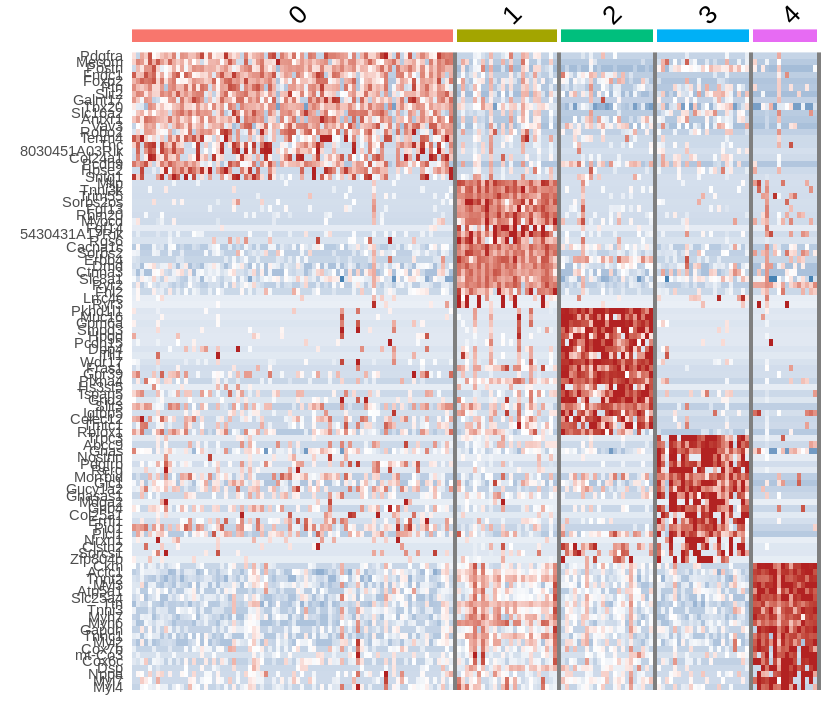

In [21]:
markers<-all.markers %>% group_by(cluster) %>% top_n(n = 20, wt = avg_log2FC)
DoHeatmap(sce1, features =markers$gene) + NoLegend() + scale_fill_gradientn(colors = c("steelblue", "white", "firebrick"))
     

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


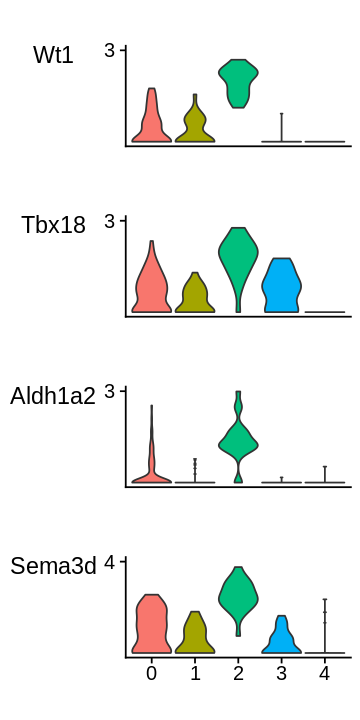

In [22]:
options(repr.plot.height=6,repr.plot.width=3)
features<- c("Wt1","Tbx18","Aldh1a2","Sema3d")
StackedVlnPlot(obj =sce1, features = features,group.by="seurat_clusters")

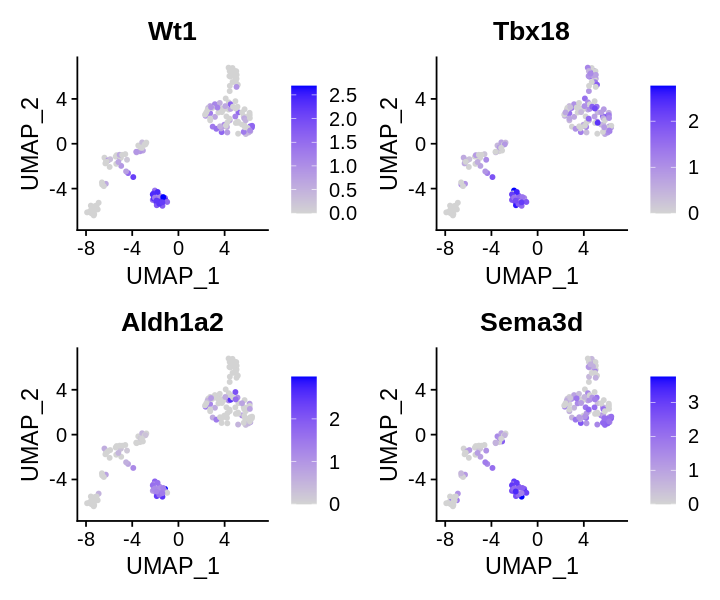

In [23]:
options(repr.plot.height=5,repr.plot.width=6)
FeaturePlot(sce1, features = features,reduction="umap")

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


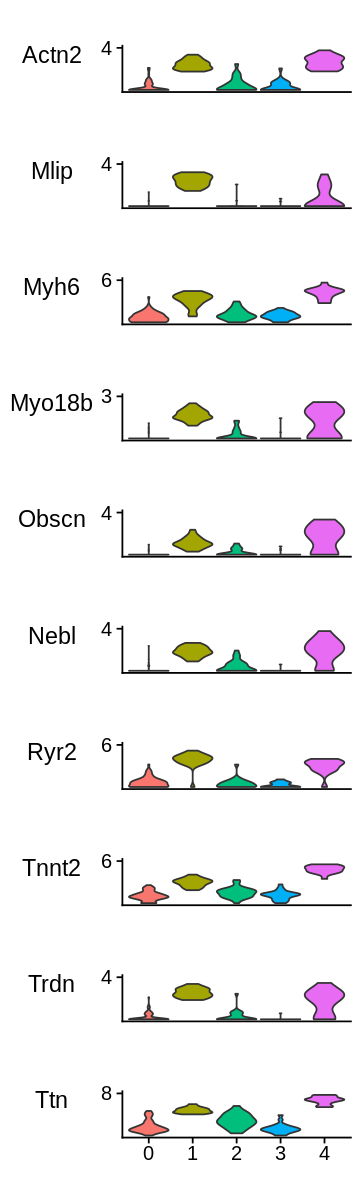

In [24]:
options(repr.plot.height=10,repr.plot.width=3)
features<- c("Actn2","Mlip","Myh6","Myo18b","Obscn","Nebl","Ryr2","Tnnt2","Trdn","Ttn")
StackedVlnPlot(obj =sce1, features = features,group.by="seurat_clusters")

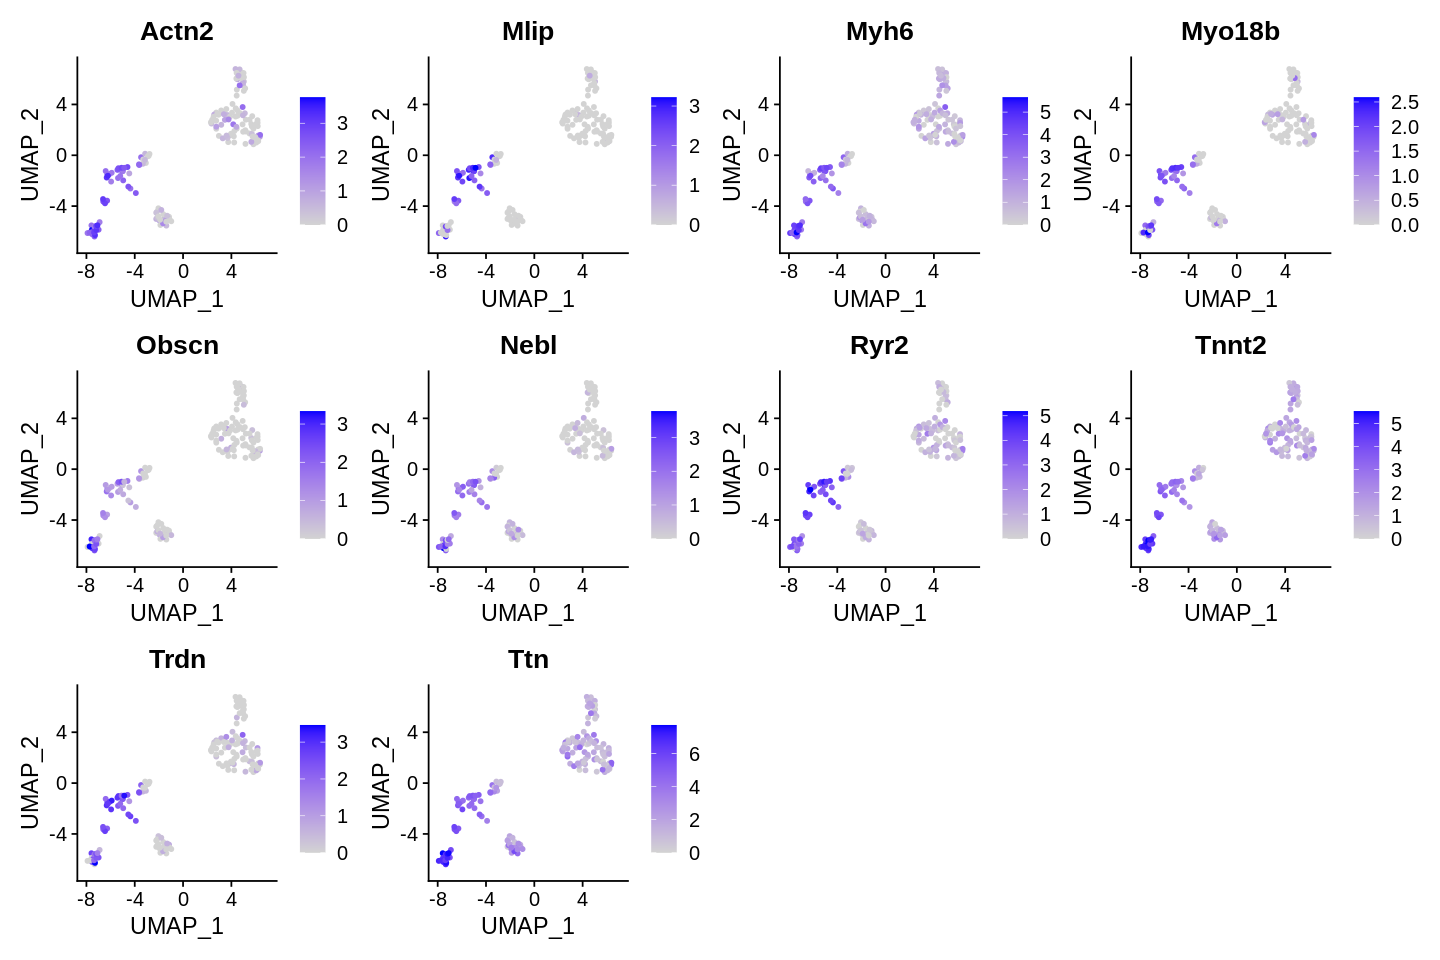

In [25]:
options(repr.plot.height=8,repr.plot.width=12)
FeaturePlot(sce1, features = features,reduction="umap")

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


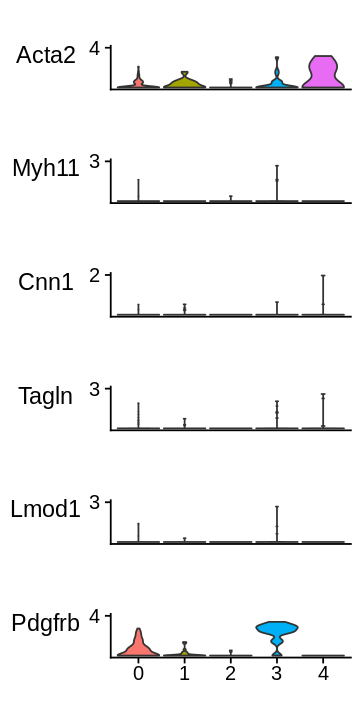

In [26]:
options(repr.plot.height=6,repr.plot.width=3)
features<- c("Acta2","Myh11","Cnn1","Tagln","Lmod1","Pdgfrb")
StackedVlnPlot(obj =sce1, features = features,group.by="seurat_clusters")

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


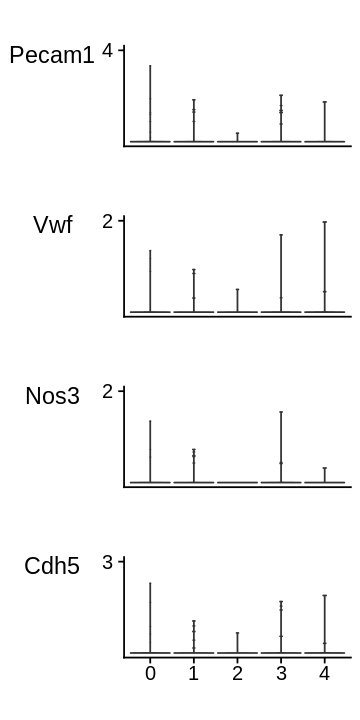

In [27]:
options(repr.plot.height=6,repr.plot.width=3)
features<- c("Pecam1","Vwf","Nos3","Cdh5")
StackedVlnPlot(obj =sce1, features = features,group.by="seurat_clusters")

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


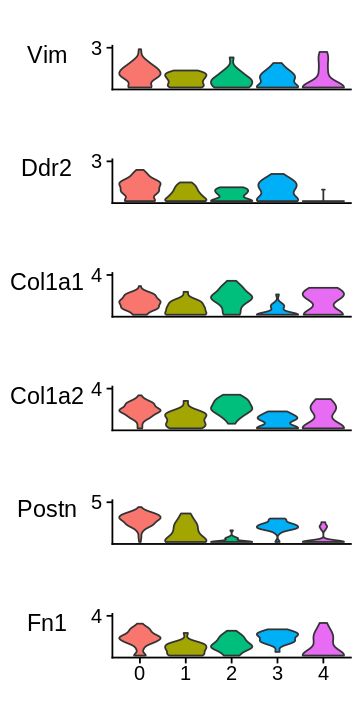

In [28]:
options(repr.plot.height=6,repr.plot.width=3)
features<- c("Vim","Ddr2","Col1a1","Col1a2","Postn","Fn1")
StackedVlnPlot(obj =sce1, features = features,group.by="seurat_clusters")

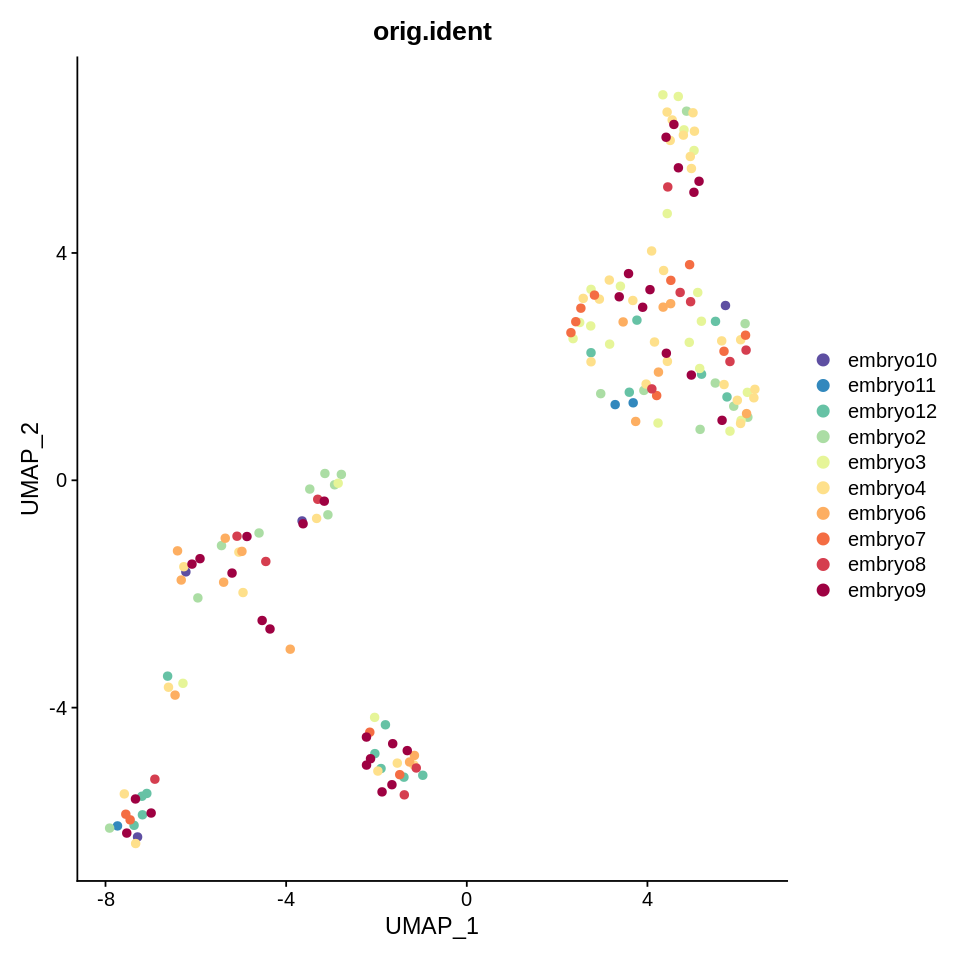

In [29]:
options(repr.plot.height=8,repr.plot.width=8)
DimPlot(sce1, group.by = "orig.ident",order=TRUE,pt.size=2,cols=rev(brewer.pal(10,'Spectral')))

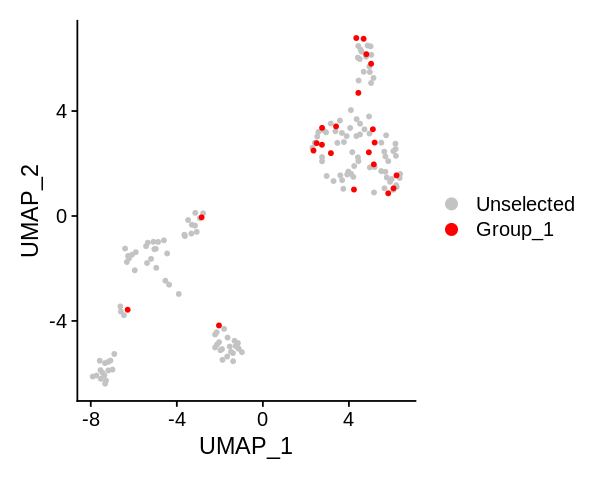

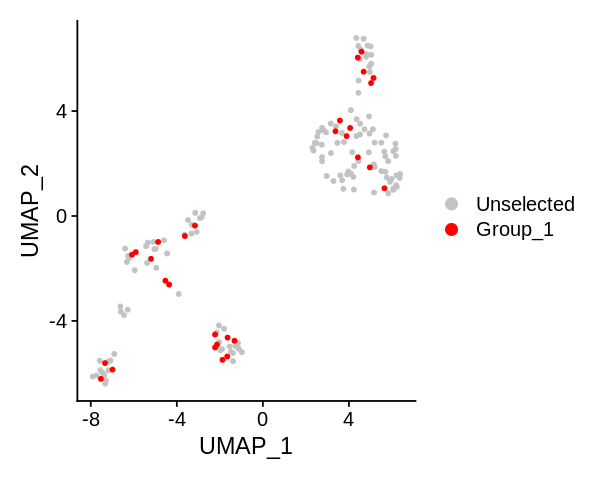

In [30]:
options(repr.plot.height=4,repr.plot.width=5)
DimPlot(sce1,cells.highlight=colnames(sce1)[which(sce1@meta.data$orig.ident == "embryo3")],cols.highlight = "red",order=TRUE,pt.size=1)
DimPlot(sce1,cells.highlight=colnames(sce1)[which(sce1@meta.data$orig.ident == "embryo9")],cols.highlight = "red",order=TRUE,pt.size=1)

In [36]:
sce1

An object of class Seurat 
32285 features across 167 samples within 1 assay 
Active assay: RNA (32285 features, 1500 variable features)
 2 dimensional reductions calculated: pca, umap

In [40]:
metadata<-rownames(sce1@meta.data)
for(i in 1:length(metadata)){
metadata[i]<-gsub('-1','',metadata[i])
}
write.table(metadata,'Sample1BC.txt',sep="\t",quote=F,row.names = F,col.names = F)

In [32]:
# The following are toy results
amp<-read.csv("./ToyAmplicon.csv")
head(amp)

,cell_bc,library,cell_id,umi,umi_id,clone_id,read
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,CCGGGATGTTATCACG,EB_FO864_RF,EB_FO864_RF_CCGGGATGTTATCACG,TCATTGTTAGTT,CCGGGATGTTATCACG_TCATTGTTAGTT,TAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGATGGAGTCGACACGACTCGCGCATACGATGGAGTCGACTACAGTCGCTACGAATATGGAGTCGATACGTAGCACGCAGACGATGGGAGCTAGAATTCTAACTAGAGCTCGCTGATCAGCCTCGACTTTGCCTTCTAGTTGCCAGCCATCTTTTGTTTCCCCCTCCCCCTTTCCTTCCTTCCCCCTGGCCCTTGCCACTCCCACTGTCCTTTCCTCCTAACATTAGTACCTTGCCTCGCACCCACCACCCACCACACCACCAACCTACCCTCGTCCACCTCCCCTCCCCACGGCTCCTATCTGTCTC,1
2,CTGCCTATCATTGCCC,EB_FO864_RF,EB_FO864_RF_CTGCCTATCATTGCCC,GATTTTGCATTT,CTGCCTATCATTGCCC_GATTTTGCATTT,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGATGGAGTCGACACGACTCGCGCATACGATGGAGTCGACTACAGTCGCTACGAATATGGAGTCGATACGTAGCACGCAGACGATGGGAGCTAGAATTCTAACTAGAGCTCGCTGATCAGCCTCGACTGTGCCTTCTCGTTGCCAGCCATCTGTTGTTTGCCCCTCCCCCGTGCCTTCCTTGACCCTGGCAGGTGCCACTCCCACTGTCCTTTCCTACTCACATGAGGAACTTGCATCGCAGACACAAAAAAAAAAAAAAAAACAAAAAACCAACTCCACCACTACACCCAAACAACTCAACACACAC,1
3,TGGTTAGCACTAAGTC,EB_FO864_RF,EB_FO864_RF_TGGTTAGCACTAAGTC,ATTTATTGGATT,TGGTTAGCACTAAGTC_ATTTATTGGATT,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGATGGAGTCGACACGACTCGCGCATACGATGGAGTCGACTACAGTCGCTACGACGATGGAGTCGCGAGCGCTATGAGCGACTATGGAGTCGATACGATACGCGCACGCTATGGAGTCGCGAGCGCGCTCGTCGCCTATGGAGTCGCGACTGTACGCCCCCGCGCTGGCTTCGATAGTCTGCGTTCACGCGATGGAGTCTAGTCGAGCCGCTGCCGTTATGGAGTCGATACGTAGCCCGCAGACGATGGGAGCTAGAATTCTAACTAGAACTCGCTGCTCCGCCTCGACTGTGCCTTCTCGTTACCAC,1
4,AGAGCGAGTCGGCTCA,EB_FO864_RF,EB_FO864_RF_AGAGCGAGTCGGCTCA,TAAGGTCAAATT,AGAGCGAGTCGGCTCA_TAAGGTCAAATT,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGATGGAGTCGACACGACTCGCGCATACGATGGAGTCGACTACAGTCGCTACGACGATGGAGTCGCGAGCGCTATGAGCGACTATGGAGTCGATACGATACGCGCACGCTATGGAGTCGAGAGCGCGCTCGTCGACTATGGAGTCGCGACTGTACGCCCACGCGATGGCGTCGCTAGTATGCGTACACGCGCTGGAGTCGCGTCGAGACGCTGACGATATGGAGTCGTTACGTCGCACGCAGACGATGGGCGCTAGAATTCTAACTAGAGCTCGCTGATCAGCCTCGACTGTGCCTTCTAGTTGCCAC,1
5,AGGCCACAGGCATGGT,EB_FO864_RF,EB_FO864_RF_AGGCCACAGGCATGGT,TCTTCTATAATT,AGGCCACAGGCATGGT_TCTTCTATAATT,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGATGGAGTCGCCACGACTCGCGCATACGATGGAGTCGACTACAGTCGCTACGACGATGGAGTCGCGAGCGCTATGAGCGACTATGGAGTCGATACGATACGCGCACGCTATGGGGTCGCGCGCGCGCTCGTCGACTCTGGAGTCTCGACTTTACTCCCCCCCTCTTCACTCTATCGTCTGCGTACCCGCTATTGAGTCCACTCTAGACGCTGCCGCTGTGGCGTCGCTACGTTGCACTCCGACGATGGGAGCTAGACTTCTCACTATTGCCCGCTGGTCCGCCTCGCCTGGCCCTCCTAAGGACCAT,1
6,CTCGGGAAGCGACGTA,EB_FO864_RF,EB_FO864_RF_CTCGGGAAGCGACGTA,CTTAGGAATCTT,CTCGGGAAGCGACGTA_CTTAGGAATCTT,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGATGGAGTCGACACGACTCGCGCATACGATGGAGTCGACTACAGTCGCTACGACGATGGAGTCGCGAGCGCTATGAGCGACTATGGAGTCGATACGATACGCGCACGCTATGGAGTCGAGAGCGCGCTCGTCGACTATGGAGTCGCGACTGTACGCACACGCGATGGCGTCGATAGTATGCGTACACGCGATGGAGTCGAGTCGCGACGCTGACGATATGGAGTCGATACGTAGCACGCAGACGCTGGGAGCTAGCATTCTAACTAGAGCTCGCTGATCAGCCTCGCCTGTACCTTCTAGTTGCCAC,1


In [33]:
sce1@meta.data$fakeclone<-amp$umi[1:167]

In [34]:
table(sce1@meta.data$fakeclone)


AAAAACGCCATT AAACATCTACTT AAACATGATTTT AAATACCCTTTT AAATAGTACCTT AAATCTTACTTT 
           1            1            1            1            1            1 
AAATGCCCTATT AACGTGTTGATT AAGTATCTAGTT AATAAAATAGTT AATTCATTTGTT ACACTAAGCCTT 
           1            1            1            1            1            1 
ACCCCTCTATTT ACCCTCAACTTT ACCGTCCTATTT ACCGTGAAGGTT ACGTCATAGGTT ACTAGAATATTT 
           1            1            1            1            1            1 
ACTCGCATCTTT ACTGAAATTTTT ACTGGTAAATTT ACTTGCTTCATT AGAAGATACATT AGCTACGATGTT 
           1            1            1            1            1            1 
AGGGCCGCGCTT AGTACGTGTTTT AGTATCCAGCTT AGTCCACAGATT ATACGCACAGTT ATATCCGTAATT 
           1            1            1            2            1            1 
ATATTATCCTTT ATCATTTGGGTT ATGCAAACATTT ATGTTAGCTATT ATTCCGCTAATT ATTCGCACGTTT 
           1            1            1            1            1            1 
ATTGATGTTTGT ATTTATTGGATT CAACCACGCATT CAACGTTGCCTT

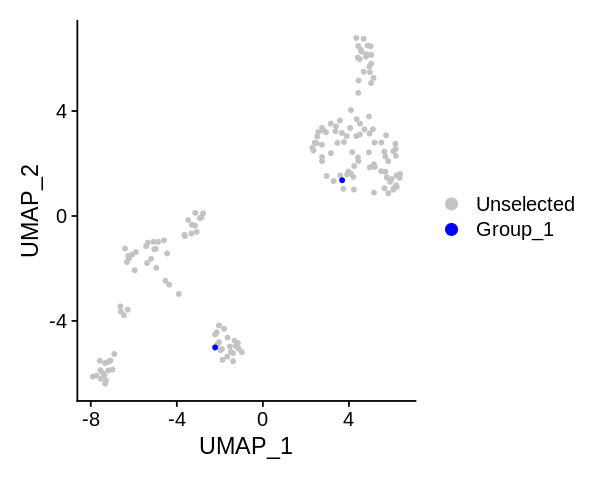

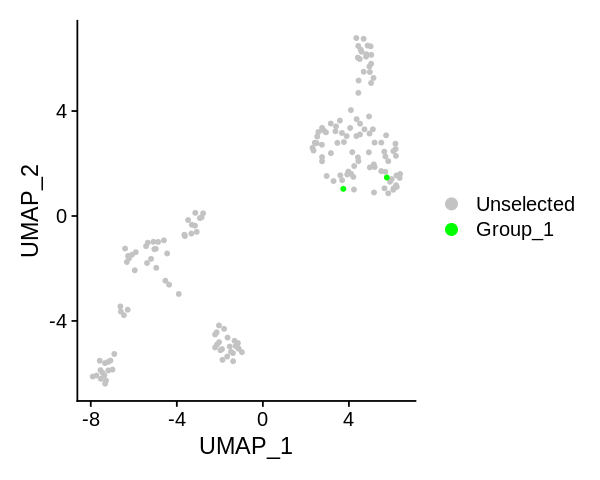

In [35]:
options(repr.plot.height=4,repr.plot.width=5)
DimPlot(sce1,cells.highlight=colnames(sce1)[which(sce1@meta.data$fakeclone == "GGATATTATTTT")],cols.highlight = "blue",order=TRUE,pt.size=1)
DimPlot(sce1,cells.highlight=colnames(sce1)[which(sce1@meta.data$fakeclone == "GCAACTTAAGTT")],cols.highlight = "green",order=TRUE,pt.size=1)